## I. Project background


As one of the largest social media websites in the world, Facebook is an attractive platform for businesses to reach their consumers. Almost all consumer-facing businesses have virtual presence on Facebook, in the form of Facebook business pages (e.g., see [here](https://www.facebook.com/target/) for Target's Facebook business page). Everyday, Facebook users who visit these business pages generate a large amount of posts. These user posts may represent customer complains, questions, or appreciations directed towards the focal businesses. 

For businesses, these user posts contain valuable information about customers' needs and preferences, and understanding what the user posts are talking about represents an important opportunity to get to know your customers in real-time.

## II. Dataset and Business Task

**Data:** labeled dataset named "FB_posts_labeled.txt". It is a **tab-delimited** file with the following fields:
- postId: this is a unique identifier for each user post. There are 7961 posts in total;
- message: this is the text of each post;
- Appreciation: this is a binary (0/1) indicator of whether a post is an appreciation;
- Complaint: this is a binary (0/1) indicator of whether a post is a customer complaint;
- Feedback: this is a binary (0/1) indicator of whether a post is a customer feedback (e.g., questions and suggestions).

​
Appreciation, Complaint, and Feedback are the three mutually exclusive content categories / classes in this dataset. They were labeled by humans, and the labeling isn't perfect (i.e., there may be ambiguous cases where the labels are not appropriate). However, for the sake of this assignment, let's treat them as the ground truth. 


**Business Task:  to build a text classifier to predict the content category of a post based on its textual content.** 


To evaluate the out-of-sample performance of your model, you will use it to make predictions for 2039 posts in an **unlabeled dataset** named "FB_posts_unlabeled.txt". It is also a tab-delimited file, but only has postId and message fields. The performance metric I will use is **averaged F-measure** across the three categories.

## III. Data Exploration

In [8]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from transformers import AutoTokenizer,TFBertModel

In [2]:
# Load data
df = pd.read_csv('FB_posts_labeled.txt', sep='\t', header=0)

label = np.argmax(df[['Appreciation', 'Complaint', 'Feedback']].values, axis=1)

df['label'] = label

df.head()

,postId,message,Appreciation,Complaint,Feedback,label
0,126016648090_10150802142013091,Great ! ;),1,0,0,0
1,108381603303_10151136215833304,YUM! YUM!,1,0,0,0
2,108381603303_3913438087739,Yummm :)),1,0,0,0
3,110455108974424_343049739048292,sweet,1,0,0,0
4,110455108974424_350358541650745,nice,1,0,0,0


In [4]:
df.shape

(7961, 6)

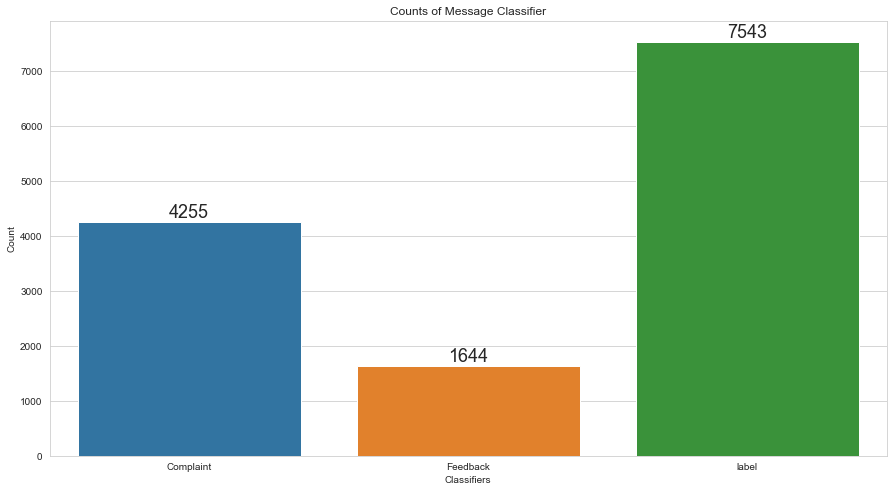

In [9]:
classifiers = list(df.iloc[:, -3:].columns.values)

plt.figure(figsize=(15,8))
sns.set_style("whitegrid")
ax= sns.barplot(x=classifiers, y=df.iloc[:, -3:].sum().values)

# Add a title and labels to the plot
plt.title("Counts of Message Classifier")
plt.xlabel("Classifiers")
plt.ylabel("Count")

#adding the text labels
rects = ax.patches
labels = df.iloc[:, -3:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

There are five columns. postId, message, Appreciation, Compliant, and Feedback. There are binary labels for the three message classifiers: Appreciation, Complaint, and Feedback. If label = 1, it indicate the message belong to that classifier.

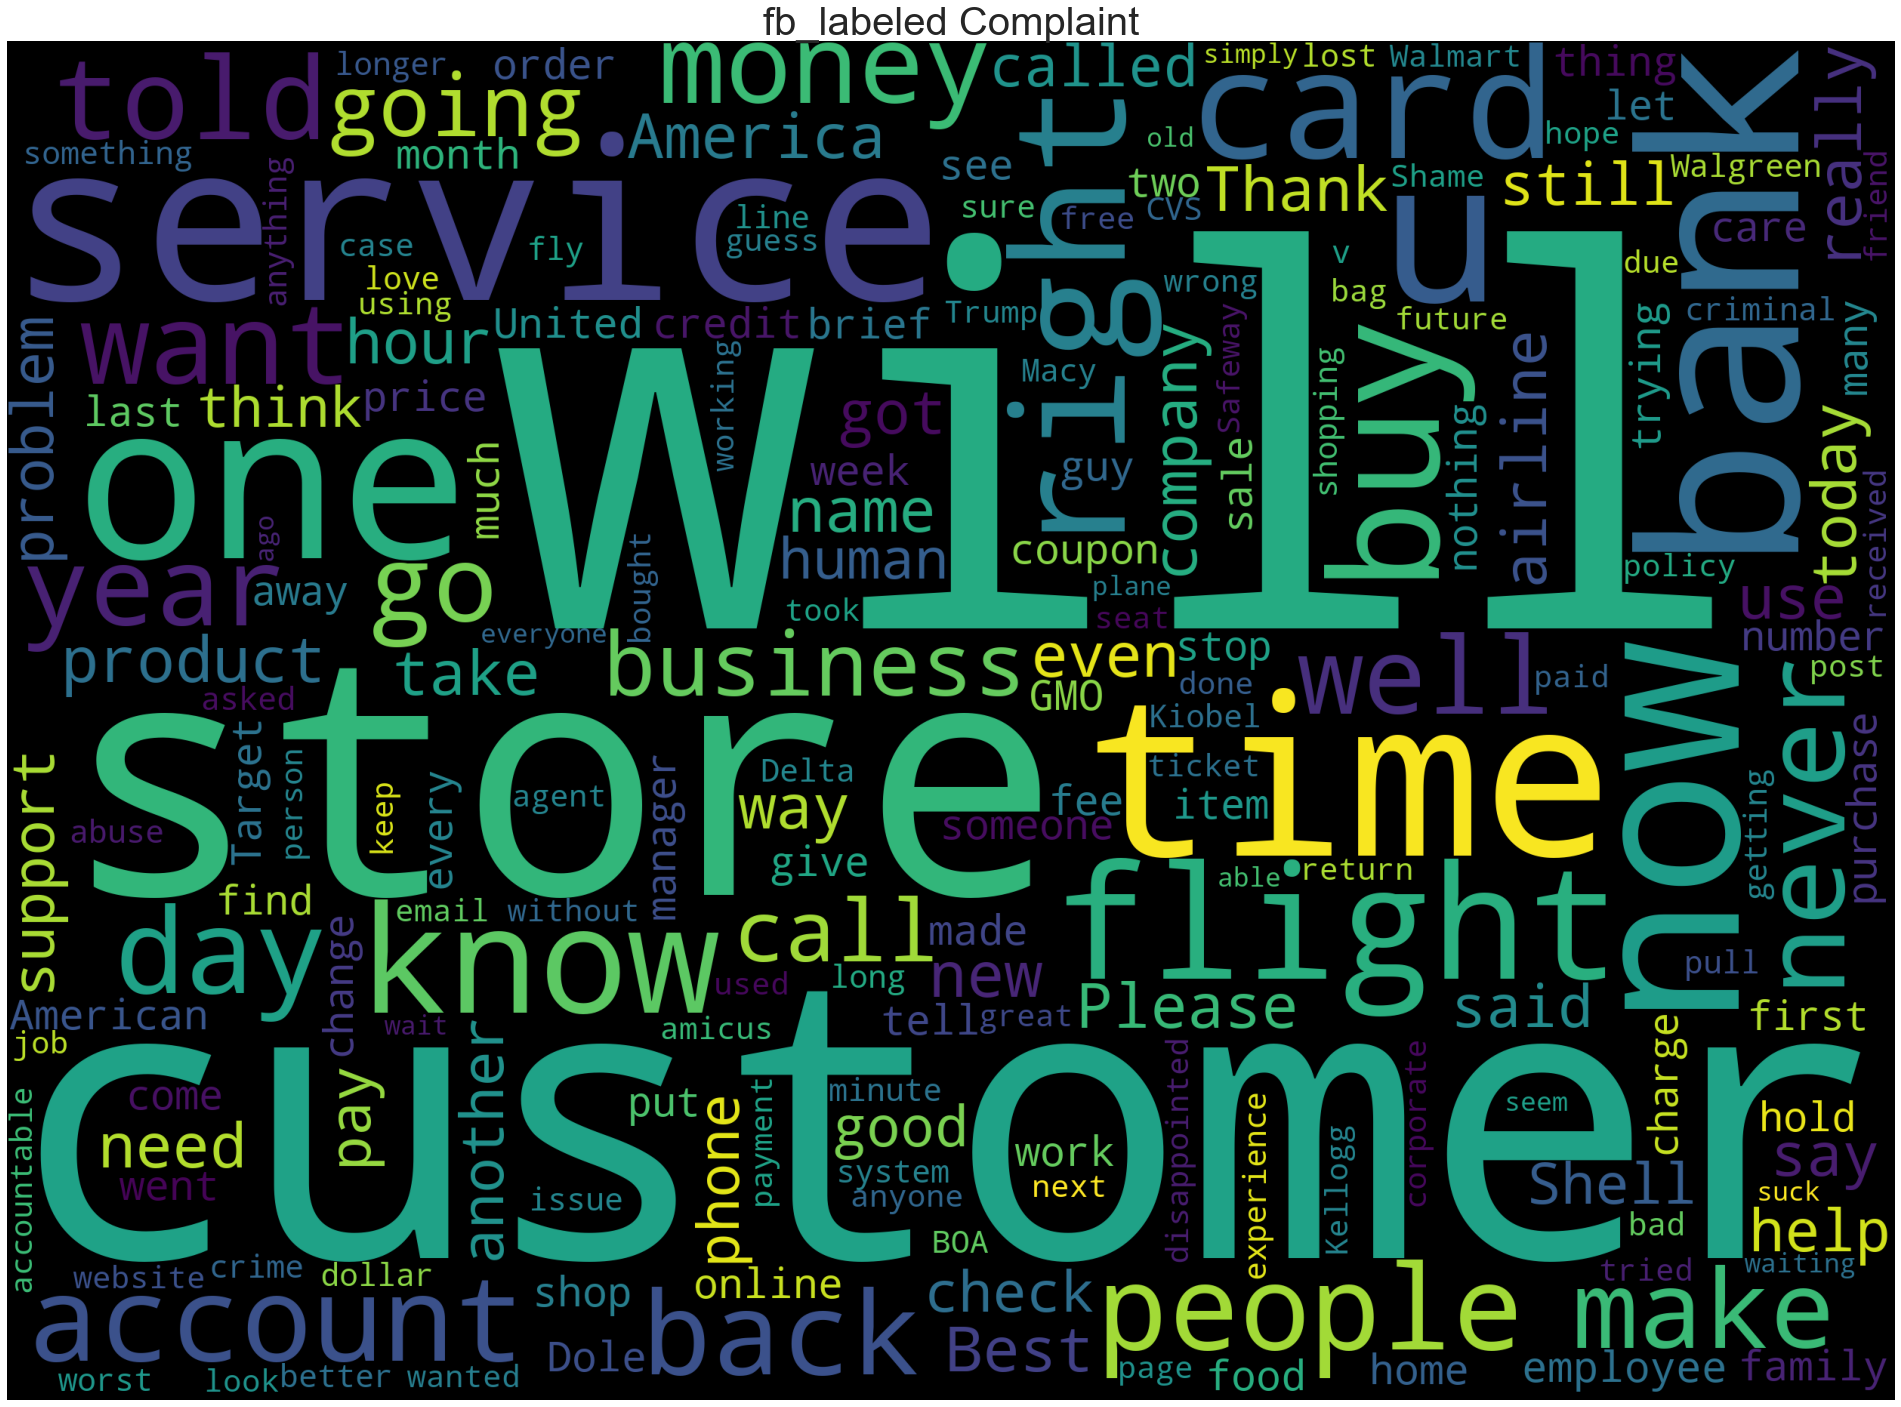

In [11]:
# most common word used with classifier of Appreciation
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))
# clean
subset = df[df.Complaint==True]
text = subset.message.values
cloud_Complaint = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("fb_labeled Complaint",fontsize=40)
plt.imshow(cloud_Complaint)

## IIII. Model - with Bert Transformer

The most challenging part of this project is how to transform the unstructed text to structured data - meaning how we can allow the machine to better understand the post. 

**Bert (Bidirectional Encoder Representations from Transformers)** is chosen to use as the text embedding layer because it is a pretrained model that can be employed to convert unstructured text into structured data more effectively. By leveraging its powerful capabilities, Bert can analyze the context of words and sentences, enabling the computer to comprehend the content of the text, extract relevant information, and represent it in a structured format suitable for further analysis and processing.

In [5]:
def format_result(y_pred_prob, post_id):
    y_pred_matrix = (y_pred_prob == y_pred_prob.max(axis=1)[:,None]).astype(int)
    df_post_id = pd.DataFrame({'postId': post_id})
    df_pred = pd.DataFrame(y_pred_matrix, columns=['Appreciation_pred', 'Complaint_pred', 'Feedback_pred'])

    if df_post_id.shape[0] != df_pred.shape[0]:
        raise ValueError('The shapes of y_pred_prob and post_id do not match')

    return df_post_id.join(df_pred)

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Split data into train and validation

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['message'], df[['Appreciation', 'Complaint', 'Feedback']].values, stratify=df['label'])

### Text Pre-Processing

In [10]:
x_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_test = tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

### Model Training

#### Set up the neural network model to perform classification with three output classes

In [11]:
max_len = 128
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(3,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [12]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model, taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = CategoricalCrossentropy()
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

#### Fit the model

In [13]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=2,
    batch_size=36
)

Epoch 1/2


166/166 [==============================] - 192s 1s/step - loss: 0.5089 - balanced_accuracy: 0.7956 - val_loss: 0.3421 - val_balanced_accuracy: 0.8759
Epoch 2/2
166/166 [==============================] - 172s 1s/step - loss: 0.2431 - balanced_accuracy: 0.9067 - val_loss: 0.3467 - val_balanced_accuracy: 0.8769


#### Predict unlabelled data

In [15]:
df_test = pd.read_csv('FB_posts_unlabeled.txt', sep='\t', header=0)
df_test.head()

,postId,message
0,108381603303_10151119973393304,Love. It. To
1,115568331790246_371841206162956,NICE
2,115568331790246_515044031842672,Congrats
3,147285781446_10151010892176447,Awesome!
4,159616034235_10150639103634236,Award


In [18]:
x_unlab = tokenizer(
    text=df_test.message.tolist(),
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [19]:
y_pred_prob = model.predict({'input_ids':x_unlab['input_ids'],'attention_mask':x_unlab['attention_mask']})

64/64 [==============================] - 25s 297ms/step


In [20]:
res_df = format_result(y_pred_prob, df_test.postId)

#### Export output to csv

In [21]:
res_df.to_csv('output.csv', index=False)